In [1]:
!unzip -q "/content/drive/MyDrive/SickleCellDataset.zip" -d "/content/SickleCellDataset"

**ENHANCE CUSTOM CNN(dropped from 81% to 72% therefore it is of no use)**

In [3]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from tqdm import tqdm

# Paths
original_neg_dir = "/content/SickleCellDataset/Negative/Clear"
augmented_neg_dir = "/content/SickleCellDataset/Negative/Clear"

# Create output directory if it doesn't exist
os.makedirs(augmented_neg_dir, exist_ok=True)

# Define augmentations (excluding basic resize/normalize for offline use)
augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
]

# List original images
image_filenames = [f for f in os.listdir(original_neg_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

# Apply each augmentation and save
for img_name in tqdm(image_filenames, desc="Augmenting Negative Images"):
    img_path = os.path.join(original_neg_dir, img_name)
    image = Image.open(img_path).convert("RGB")

    for i, transform in enumerate(augmentations):
        transformed_image = transform(image)
        base_name = os.path.splitext(img_name)[0]
        save_path = os.path.join(augmented_neg_dir, f"{base_name}_aug{i+1}.jpg")
        transformed_image.save(save_path)


Augmenting Negative Images: 100%|██████████| 147/147 [00:04<00:00, 32.96it/s]


In [4]:
import os

# Path to the folder where all negative images (original + augmented) are stored
neg_dir = "/content/SickleCellDataset/Negative/Clear"

# Count all files with image extensions
image_extensions = (".jpg", ".jpeg", ".png")
total_images = len([f for f in os.listdir(neg_dir) if f.lower().endswith(image_extensions)])

print(f"Total negative images: {total_images}")


Total negative images: 441


In [5]:
import os
import shutil
import random
from pathlib import Path

# Set seed for reproducibility
random.seed(42)

# Paths
base_dir = "/content/SickleCellDataset"
pos_dir = os.path.join(base_dir, "Positive", "Unlabelled")
neg_dir = os.path.join(base_dir, "Negative", "Clear")

# Destination structure
splits = ["train", "val", "test"]
split_ratio = [0.7, 0.15, 0.15]

# Create directory structure
for split in splits:
    for label in ["Positive", "Negative"]:
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

def split_and_copy_images(image_list, label, output_base):
    random.shuffle(image_list)
    total = len(image_list)
    train_end = int(split_ratio[0] * total)
    val_end = train_end + int(split_ratio[1] * total)

    split_lists = {
        "train": image_list[:train_end],
        "val": image_list[train_end:val_end],
        "test": image_list[val_end:]
    }

    for split, imgs in split_lists.items():
        dest_dir = os.path.join(output_base, split, label)
        for img_path in imgs:
            shutil.copy(img_path, dest_dir)

# Get image paths
pos_images = list(Path(pos_dir).glob("*.jpg"))
neg_images = list(Path(neg_dir).glob("*.jpg"))

# Split and copy
split_and_copy_images(pos_images, "Positive", base_dir)
split_and_copy_images(neg_images, "Negative", base_dir)

print("Dataset split complete.")


Dataset split complete.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transformations (as used earlier)
fine_tune_transforms = {
    "train": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load your saved custom CNN model
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 19 * 20, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load datasets
data_dir = "/content/SickleCellDataset"  # Path to your fine-tuning data
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=fine_tune_transforms["train"])
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=fine_tune_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc
def validate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

# Initialize the custom CNN model and load the weights if necessary
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/SickleCellModels/custom_cnn_best.pth", map_location=device))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Fine-tuning loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/fine_cnn.pth")
        print("→ Saved best model\n")

print("\nFine-tuning complete.")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Val: 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


Train Loss: 0.8209, Train Acc: 0.5158
Val   Loss: 0.6937,   Val   Acc: 0.5659
→ Saved best model


Epoch 2/10


Val: 100%|██████████| 5/5 [00:23<00:00,  4.75s/it]


Train Loss: 0.6761, Train Acc: 0.5954
Val   Loss: 0.6796,   Val   Acc: 0.6047
→ Saved best model


Epoch 3/10


Val: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]


Train Loss: 0.6407, Train Acc: 0.6269
Val   Loss: 0.6440,   Val   Acc: 0.6124
→ Saved best model


Epoch 4/10


Val: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


Train Loss: 0.6293, Train Acc: 0.6103
Val   Loss: 0.6820,   Val   Acc: 0.5969

Epoch 5/10


Val: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


Train Loss: 0.5904, Train Acc: 0.6501
Val   Loss: 0.7223,   Val   Acc: 0.6512
→ Saved best model


Epoch 6/10


Val: 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]


Train Loss: 0.5583, Train Acc: 0.6750
Val   Loss: 0.5384,   Val   Acc: 0.7054
→ Saved best model


Epoch 7/10


Val: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


Train Loss: 0.5171, Train Acc: 0.6750
Val   Loss: 0.7333,   Val   Acc: 0.6744

Epoch 8/10


Val: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


Train Loss: 0.5279, Train Acc: 0.6998
Val   Loss: 0.5363,   Val   Acc: 0.6822

Epoch 9/10


Val: 100%|██████████| 5/5 [00:24<00:00,  5.00s/it]


Train Loss: 0.4958, Train Acc: 0.7247
Val   Loss: 0.4734,   Val   Acc: 0.8062
→ Saved best model


Epoch 10/10


Val: 100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


Train Loss: 0.4919, Train Acc: 0.7297
Val   Loss: 0.4239,   Val   Acc: 0.8140
→ Saved best model


Fine-tuning complete.


In [7]:
drive_folder = "/content/drive/My Drive/SickleCellModels"
model = drive_folder + "/fine_cnn.pth"
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/fine_cnn.pth', drive_folder + "/fine_cnn.pth")

'/content/drive/My Drive/SickleCellModels/fine_cnn.pth'

Using device: cpu


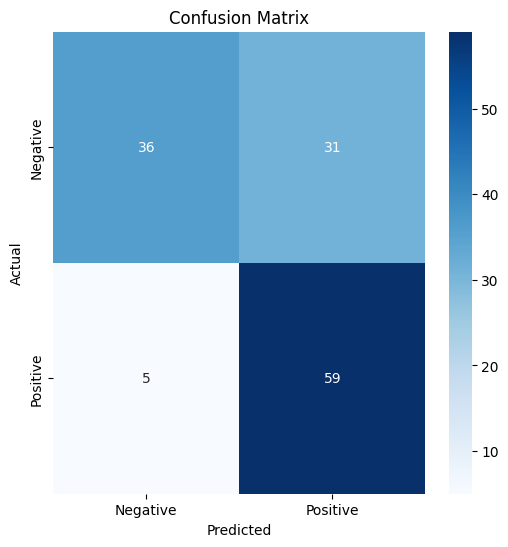

Test Accuracy: 72.52%

Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.54      0.67        67
    Positive       0.66      0.92      0.77        64

    accuracy                           0.73       131
   macro avg       0.77      0.73      0.72       131
weighted avg       0.77      0.73      0.72       131



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transformations for testing
test_transforms = transforms.Compose([
    transforms.Resize((306, 320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dir = "/content/SickleCellDataset/test"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load your fine-tuned model
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/SickleCellModels/fine_cnn.pth", map_location=device))
model.eval()

# Testing loop
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy
accuracy = sum([cm[i, i] for i in range(len(test_dataset.classes))]) / cm.sum()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print("\nClassification Report:\n")
print(report)


**Applied XAI->GRAD CAM on all models**

Predicted Label: Sickle (Anemic)


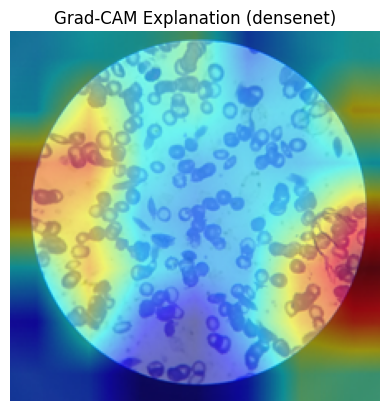

In [34]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ----- Set device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Preprocessing per model type -----
def get_transform(model_type):
    if model_type in ["resnet", "densenet", "efficientnet"]:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    elif model_type == "custom":
        return transforms.Compose([
            transforms.Resize((306, 320)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("Unknown model type")

# ----- Load Image -----
def preprocess_image(image_path, model_type):
    transform = get_transform(model_type)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# ----- Load Model -----
def load_model(model_type, model_path):
    if model_type == "resnet":
        from torchvision.models import resnet18
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)

    elif model_type == "densenet":
        from torchvision.models import densenet121
        model = densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, 2)

    elif model_type == "efficientnet":
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    elif model_type == "custom":
        class ImprovedCNN(nn.Module):
            def __init__(self):
                super(ImprovedCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.dropout = nn.Dropout(0.5)
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 19 * 20, 256),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 2)
                )

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

        model = ImprovedCNN()

    else:
        raise ValueError("Unsupported model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# ----- Predict -----
def predict(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    image_tensor = preprocess_image(image_path, model_type)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    label = "Healthy" if predicted.item() == 0 else "Sickle (Anemic)"
    print(f"Predicted Label: {label}")
    return label
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np

# ----- Get Target Layer for Grad-CAM -----
def get_target_layer(model, model_type):
    if model_type == "resnet":
        return model.layer4[-1]
    elif model_type == "densenet":
        return model.features[-1]
    elif model_type == "efficientnet":
        return model.features[-1]
    elif model_type == "custom":
        return model.features[-1]  # Last conv block in custom CNN
    else:
        raise ValueError("Unsupported model type")

# ----- Grad-CAM Visualization -----
def apply_gradcam(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    model.eval()

    # Get target layer
    target_layer = get_target_layer(model, model_type)

    # Load and preprocess image
    transform = get_transform(model_type)
    image_pil = Image.open(image_path).convert("RGB")
    input_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Move model to CPU
    model = model.to("cpu")

    # Create GradCAM without `use_cuda`
    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(1)]  # Class 1 = Sickle (Anemic)

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Prepare image for visualization
    rgb_img = np.array(image_pil.resize((224, 224 if model_type != "custom" else 320))).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Display heatmap
    plt.imshow(visualization)
    plt.title(f"Grad-CAM Explanation ({model_type})")
    plt.axis("off")
    plt.show()


# ----- Example usage -----
image_path = "/content/5.jpg"
model_type = "densenet" #"resnet"  # or "densenet", "efficientnet", "custom"
model_path = "/content/drive/MyDrive/SickleCellModels/fine_tuned_densenet.pth"
predict(image_path, model_type, model_path)
apply_gradcam(image_path, model_type, model_path)



In [35]:
!pip install lime scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5823b8cfa44946065d31a29c385a10d52c1ec8616729827dbe58bad91a773c72
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**XAI->LIME(didn't work)**

In [36]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from lime import lime_image
from skimage.segmentation import mark_boundaries

# ----- Set device -----
device = torch.device("cpu")  # Force CPU

# ----- Preprocessing per model type -----
def get_transform(model_type):
    if model_type in ["resnet", "densenet", "efficientnet"]:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    elif model_type == "custom":
        return transforms.Compose([
            transforms.Resize((306, 320)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("Unknown model type")

# ----- Load Image -----
def preprocess_image(image_path, model_type):
    transform = get_transform(model_type)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# ----- Load Model -----
def load_model(model_type, model_path):
    if model_type == "resnet":
        from torchvision.models import resnet18
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)

    elif model_type == "densenet":
        from torchvision.models import densenet121
        model = densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, 2)

    elif model_type == "efficientnet":
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    elif model_type == "custom":
        class ImprovedCNN(nn.Module):
            def __init__(self):
                super(ImprovedCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.dropout = nn.Dropout(0.5)
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 19 * 20, 256),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 2)
                )

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

        model = ImprovedCNN()

    else:
        raise ValueError("Unsupported model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# ----- LIME Explanation -----
def explain_with_lime(model, image_path, model_type):
    original_image = Image.open(image_path).convert("RGB")

    # Convert PIL to numpy
    image_np = np.array(original_image)

    # LIME explainer
    explainer = lime_image.LimeImageExplainer()

    def batch_predict(images):
        model.eval()
        transform = get_transform(model_type)
        batch = torch.stack([transform(Image.fromarray(img)).to(device) for img in images], dim=0)
        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000  # more samples = more stable explanation
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation ({model_type})")
    plt.axis('off')
    plt.show()

# ----- Predict -----
def predict(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    image_tensor = preprocess_image(image_path, model_type)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    label = "Healthy" if predicted.item() == 0 else "Sickle (Anemic)"
    print(f"Predicted Label: {label}")

    # Run LIME explanation
    explain_with_lime(model, image_path, model_type)

    return label

# ----- Example usage -----
image_path = "/content/5.jpg"
model_type = "custom"  # or "resnet", "densenet", "efficientnet"
model_path = "/content/drive/MyDrive/SickleCellModels/fine_cnn.pth"
predict(image_path, model_type, model_path)


Predicted Label: Sickle (Anemic)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

**XAI->SHAP(didn't work)**

In [37]:
!pip install shap

In [38]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ----- Set device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Preprocessing per model type -----
def get_transform(model_type):
    if model_type in ["resnet", "densenet", "efficientnet"]:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    elif model_type == "custom":
        return transforms.Compose([
            transforms.Resize((306, 320)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("Unknown model type")

# ----- Load Image -----
def preprocess_image(image_path, model_type):
    transform = get_transform(model_type)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# ----- Load Model -----
def load_model(model_type, model_path):
    if model_type == "resnet":
        from torchvision.models import resnet18
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)

    elif model_type == "densenet":
        from torchvision.models import densenet121
        model = densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, 2)

    elif model_type == "efficientnet":
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    elif model_type == "custom":
        class ImprovedCNN(nn.Module):
            def __init__(self):
                super(ImprovedCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.dropout = nn.Dropout(0.5)
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 19 * 20, 256),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 2)
                )

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

        model = ImprovedCNN()

    else:
        raise ValueError("Unsupported model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# ----- Predict -----
def predict(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    image_tensor = preprocess_image(image_path, model_type)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    label = "Healthy" if predicted.item() == 0 else "Sickle (Anemic)"
    print(f"Predicted Label: {label}")
    return label
import shap
import numpy as np

# ----- SHAP Explain -----
def explain_with_shap(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    model.eval()

    # Preprocess the input image
    image_tensor = preprocess_image(image_path, model_type)
    image_tensor.requires_grad_()  # Required for gradient-based SHAP

    # Create a background dataset: here we just use a zero tensor
    background = torch.zeros_like(image_tensor).to(device)

    # Use GradientExplainer for CNN-based models
    explainer = shap.GradientExplainer(model, background)

    # Explain the model's prediction on this single image
    shap_values, indexes = explainer.shap_values(image_tensor)

    # Convert tensor image to numpy and unnormalize for visualization
    def unnormalize(img_tensor):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        img = std * img + mean
        return np.clip(img, 0, 1)

    img = unnormalize(image_tensor)

    # Plot SHAP values
    shap.image_plot(shap_values, [img])
#USAGE
image_path = "/content/5.jpg"
model_type = "densenet" #"resnet"  # or "densenet", "efficientnet", "custom"
model_path = "/content/drive/MyDrive/SickleCellModels/fine_tuned_densenet.pth"
predict(image_path, model_type, model_path)
explain_with_shap(image_path, model_type, model_path)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted Label: Sickle (Anemic)


ValueError: not enough values to unpack (expected 2, got 1)